In [1]:
import re
import os
import sys
import pickle
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KDTree
from collections import Counter

sys.path.append('../src/')
from text_preprocessing import *
%matplotlib inline

In [2]:
def flatten_lists(lst):
    """Remove nested lists."""
    return [item for sublist in lst for item in sublist]

def tagged_documents(documents, labels):
    """Tag preprocessed document with its name.

    Args:
        documents (list, str): Nested lists with preprocessed tokens.
        labels (list, str): The tag for each nested list.

    Return:
        TaggedDocument object of the form (words=[tokens], tag=[label]).

    """

    return [gensim.models.doc2vec.TaggedDocument(documents[i], [labels[i]]) for i in range(len(labels))]

def bigrams(documents):
    """Create bigrams using Gensim's phrases."""
    phrases = gensim.models.Phrases(documents)
    bigram = gensim.models.phrases.Phraser(phrases)
    return list(bigram[documents])

## Text Preprocessing

Preprocessing the project abstracts:

1. Remove stopwords and punctuation
2. Find bigrams
3. Create tuples of preprocessed documents and project titles for doc2vec

In [3]:
df = pd.read_csv('../data/interim/research_grants.csv')

/Users/kstathou/anaconda/envs/nesta/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head(1)

,Unnamed: 0,Grant Offered (£),LAD13NM,Participant Name,Postcode,Project Start Date,Project Title,Public Description,dataset_id,project_id
0,0,101720,Coventry,University of Warwick,NaN,2010,Random Fields of Gradients,Random fields of gradients are a class of mode...,gtr,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B391...


In [5]:
nlproc = TextPreprocessing()

In [6]:
%%time
documents = [flatten_lists(nlproc.tokenize_document(doc)) for doc in list(df['Public Description'])]

CPU times: user 2min 55s, sys: 1.26 s, total: 2min 57s
Wall time: 2min 57s


In [7]:
# Find bigrams
docs = bigrams(documents)
project_titles = list(df['Project Title'])

## Training word2vec, doc2vec

Word2vec is used to expand the list of query words with other that are semantically similar. Doc2vec is used to transform the documents to vectors and then split the high dimensional space with KD Tree.

In [8]:
%%time
w2v = gensim.models.Word2Vec(docs, size=350, window=10, min_count=2, iter=20)

CPU times: user 19min 18s, sys: 7.19 s, total: 19min 25s
Wall time: 6min 39s


In [10]:
# w2v.save('../models/w2v_main.word2vec')

In [15]:
w2v.most_similar('machine_learning')

[('artificial_intelligence', 0.6850327253341675),
 ('deep_learning', 0.677425742149353),
 ('data_mining', 0.620207667350769),
 ('computer_vision', 0.6097780466079712),
 ('machine-learning', 0.577206015586853),
 ('data_analytics', 0.5466424226760864),
 ('algorithms', 0.5164541006088257),
 ('pattern_matching', 0.5130344033241272),
 ('discriminative', 0.5085511803627014),
 ('pattern_recognition', 0.5077463984489441)]

In [11]:
# create Tagged Documents (Gensim object) that will be used as input for the doc2vec
tagged_tags = tagged_documents(documents=docs, labels=project_titles)

In [12]:
%%time
d2v = gensim.models.doc2vec.Doc2Vec(documents=tagged_tags, size=350, min_count=2, 
                                    window=30, iter=30, dbow_words=1, dm=0)

CPU times: user 7h 47min 47s, sys: 1min 18s, total: 7h 49min 6s
Wall time: 2h 36min 54s


In [16]:
# d2v.save('../models/d2v_main.doc2vec')

In [13]:
# with open('../data/interim/project_documents_main.pickle', 'wb') as h:
#     pickle.dump(docs, h)

In [4]:
# with open('../data/interim/project_documents_main.pickle', 'rb') as h:
#     project_documents = pickle.load(h)

In [107]:
class Tfidf():
    """Base class that calculates the TF-IDF weighting of text."""
    def __init__(self, docs):
        """Args:
            documents (list, str): Nested lists with preprocessed tokens. Example: [['foo', 'bar'], ['alpha', 'beta']]

        """
        self.documents = docs

    def tfidf_transformer(self):
        """Calculates the TF-IDF of preprocessed text."""
        tfidf = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False)
        X = tfidf.fit_transform(self.documents)
        feature_names = tfidf.get_feature_names()
        return tfidf, X, feature_names

class WordQueries(Tfidf):
    """Find the words to query the InnovateUK data with. Inherits from Tfidf class."""
    def __init__(self, word2vec, docs):
        """Args:
            w2v (word2vec): Pretrained word vectors.
            tfidf (sparse matrix): Sparse matrix of the form (Document x Words) with the TF-IDF weights as values.

        """
        super().__init__(docs)
        self.w2v = word2vec
        self.tfidf, _, _ = self.tfidf_transformer()

    def similar_tokens(self, word):
        """Find the most similar words using a pretrained word2vec model.

        Args:
            word (str): Query word.

        Returns:
            words (set, str): Top 20 most similar to the input words. Similarity is given by word2vec. The input term is also added to the set.

        """
        # Add the query word directly into the list because it will not be in the similar ones.
        words = [word]
#         for token in [tup[0] for tup in self.w2v.most_similar([word], topn=20)]:
#             words.extend([tup[0] for tup in self.w2v.most_similar([token], topn=25) if tup[1] > 0.55])

        words.extend([tup[0] for tup in self.w2v.most_similar([word], topn=20)])
        return set(words)

    def word2ids(self, tokens):
        """Find the TF-IDF IDs of tokens. 

        Args:
            tokens (set, str): Unique, preprocessed tokens.

        Returns:
            token_ids(list, int): Token IDs of the TF-IDF dictionary.

        """
        token_ids = []
        for token in set(tokens):
            try:
                token_ids.append(self.tfidf.vocabulary_[token])
            except Exception as e:
                continue
        return token_ids

    def high_idf_ids(self, token_ids):
        """Filter out tokens with extreme TF-IDF weights (both rare terms and common ones).

        Args:
            token_ids: (list, int): Token IDs of the TF-IDF dictionary.

        Returns:
            ids: (list, int): Token IDs of the TF-IDF dictionary.

        """
        idfs = {token_id:self.tfidf.idf_[token_id] for token_id in token_ids}
        ids = [k for k, v in idfs.items() if v >= np.percentile([val for val in idfs.values()], [35])[0]
        and v < np.percentile([val for val in idfs.values()], [95])[0]]
        return ids

    def tfidf_id2word(self, id_):
        """Find a token using its TF-IDF ID.

        Args:
            id_ (int): TF-IDF id of a token.

        Returns:
            Token (str) that corresponds to the TF-IDF id.

        """
        return list(self.tfidf.vocabulary_.keys())[list(self.tfidf.vocabulary_.values()).index(id_)]

    def query_word(self, word):
        """Wrapper function around the WordQueries class.

        Args:
            word (str): Token to query the engine with.

        Returns:
            queries (set, str): Unique tokens that are similar to the queried word and do not belong into the extremes.

        """
        sim_tokens = self.similar_tokens(word)
        token_ids = self.word2ids(sim_tokens)
        high_ids = self.high_idf_ids(token_ids)
        queries = [self.tfidf_id2word(id_) for id_ in high_ids]
        queries.append(word)
        return set(queries)

class GtrSearch(WordQueries):
    """Search the InnovateUK dataset using a term and retrieve projects that are relevant to it. 

    TODO: 
    * Change class name.
    * It now returns unique projects, we should maybe expand it a bit more. Check how this messes up the pretrained paragraph vectors.
    * Change the names of the composed classes from feature, feature2 to something else.

    """
    def __init__(self, dataframe, documents, word2vec):
        """Args:
            feature: Instance of the Tfidf class.
            feature2: Instance of the WordQueries class.
            df: Pandas dataframe that contains the InnovateUK data.

        """
        self.feature = Tfidf(documents)
        self.feature2 = WordQueries(word2vec, documents)
        self.df = dataframe
        self.kdt = KDTree(self.df['paragraph vectors'].tolist(), leaf_size=3)

    def query_kdt(self, query, num_results):
        """Create a KDTree using the pretrained paragraph vectors and query it with a project title.

        Args:
            query (str): Project title from the InnovateUK dataset.

        Returns:
            dist (array, float): Euclidean distance between the query term and the results.
            idx (array, int): Index of the results, ordered by their distance to the query (ascending order).

        """
        
        return self.kdt.query(self.df['paragraph vectors'][self.df['Project Title'] == query].tolist(), k=num_results)

    def relevant_doc_ids(self, idx, keywords):
        """Find the relevant documents IDs based on their intersection with the query words.

        Args:
            idx (array, int): Index of relevant paragraph vectors, ordered by their distance to the query (ascending order).
            keywords (set, str): Query terms.

        Returns:
            List of document indexes (int) that have at least one word the same with the query terms.

        """
        return [id_ for id_ in idx[0] if len(keywords.intersection(self.feature.documents[id_])) >= 1]
    
    def search_queries(self, word):
        """Wrapper function around the GtrSearch class.

        Args:
            word (str): Query term to search the dataset with.

        Returns:
            Subset of the dataframe with unique projects that are relevant to the query term.

        """
        m = self.feature2.query_word(word)

        print(m)
        inter = {i:len(m.intersection(doc)) for i, doc in enumerate(self.feature.documents)}
        c = [v for k,v in inter.items()]
        max_id = list(inter.keys())[list(inter.values()).index(max(c))]
        
        dist, idx = self.query_kdt(query=self.df.iloc[max_id, 6], num_results=self.df.shape[0])
        
        idx = self.relevant_doc_ids(idx, m)
        
        return self.df.iloc[idx, :]

In [13]:
word_vectors = gensim.models.Word2Vec.load('../models/w2v_main.word2vec')
doc_vectors = gensim.models.Doc2Vec.load('../models/d2v_main.doc2vec')
with open('../data/interim/project_documents_main.pickle', 'rb') as h:
    text_documents = pickle.load(h)
    
df['paragraph vectors'] = [doc_vectors.docvecs[title] for title in df['Project Title']]

df.reset_index(inplace=True, drop=True)

In [108]:
gtrs = GtrSearch(df, text_documents, word_vectors)

In [109]:
search_results = gtrs.search_queries('machine_learning')

{'deep_learning', 'data_mining', 'information_retrieval', 'machine-learning', 'software_engineering', 'text_mining', 'data-driven', 'machine_learning', 'pattern_recognition', 'bayesian', 'data_analytics', 'natural_language', 'sensor_fusion'}


In [112]:
search_results.shape

(1662, 11)

In [110]:
search_results.to_csv('../data/interim/df_search_results.csv')

In [111]:
Counter(search_results.dataset_id)

Counter({'H2020': 465, 'gtr': 805, 'innovateuk': 392})

## Visualising the results

In [113]:
# UK participation in H2020 VR projects
h2020 = pd.read_csv('../data/raw/cordis-h2020projects.csv', sep=';')

# H2020 VR projects
proj = list(search_results[search_results.dataset_id=='H2020']['project_id'])

# Slice H2020
participationcountries = h2020[h2020.id.isin(proj)][['participantCountries', 'id']]
participationcountries.set_index('id',inplace=True)

# Keep the index of observations where UK is in participationcountries 
uk_h2020_id = [idx for idx, cc in zip(participationcountries.index, participationcountries.participantCountries) 
               if type(cc) ==str and 'UK' in cc]

print('PERCENTAGE OF H2020 PROJECTS WITH UK PARTICIPATION: {}%'.format(len(uk_h2020_id) * 100 / Counter(search_results.dataset_id)['H2020']))

PERCENTAGE OF H2020 PROJECTS WITH UK PARTICIPATION: 22.795698924731184%


In [114]:
# remove results without UK participation
search_results = search_results[~search_results.project_id.isin(set(search_results[search_results.dataset_id=='H2020']['project_id']) - set(uk_h2020_id))]

In [115]:
search_results.shape

(1232, 11)

In [116]:
# Some wrangling
search_results['year'] = search_results['Project Start Date'].apply(lambda x: str(x)[:4])
search_results = search_results[search_results['Grant Offered (£)'].isnull()==False]
search_results.reset_index(inplace=True)

In [117]:
# EUR to GBP for h2020 projects
for i in range(search_results.shape[0]):
    if search_results.loc[i, 'dataset_id'] == 'H2020':
        search_results.loc[i, 'Grant Offered (£)'] = float(str(search_results.loc[i, 'Grant Offered (£)']).split(',')[0]) * 0.89
    else:
        search_results.loc[i, 'Grant Offered (£)'] = float(search_results.loc[i, 'Grant Offered (£)'])

In [121]:
money = search_results[['year', 'Grant Offered (£)']].groupby('year').sum()['Grant Offered (£)']

c=0
money_dict = {}
for i in range(1, len(money)):
    try:
        money_dict['-'.join([money.index[c+i-1], money.index[c+i]])] = money[c+i-1] + money[c+i]
        c+=1
    except IndexError as e:
        break
        
funding = pd.DataFrame.from_dict(money_dict, orient='index') / 1000000
funding.rename(index=str, inplace=True, columns={0:'Funding'})

In [126]:
sorted_funding = funding.iloc[[3,-1,-3,0,1,2, -2]]

In [128]:
pc = search_results.groupby(['year', 'dataset_id']).count()['project_id'].unstack('dataset_id').fillna(0)

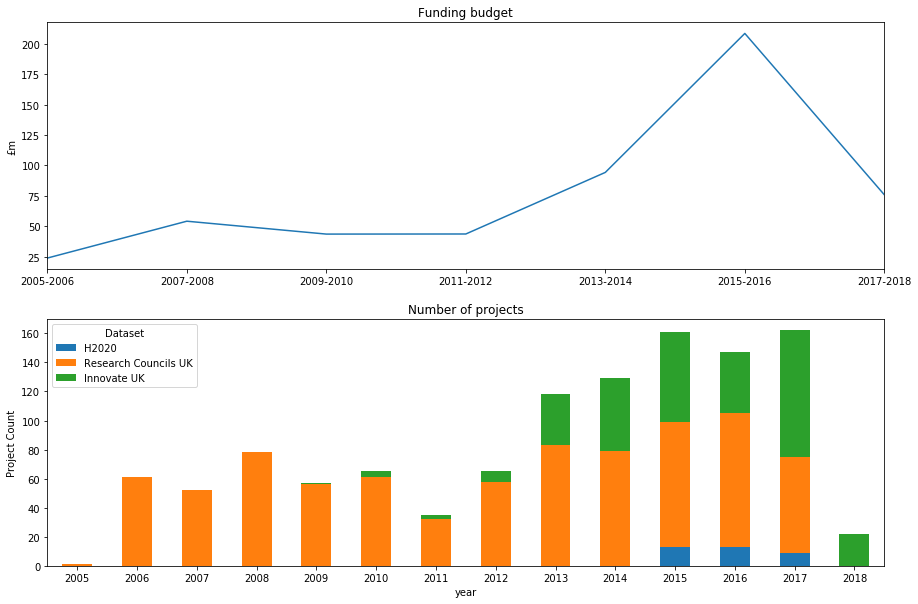

In [131]:
f, (ax1,ax2) = plt.subplots(nrows=2, figsize=(15,10))

# sorted_funding.div(sorted_funding.iloc[0, ]).plot(ax=ax3, legend=False)
# ax3.set_title('Level of funding (base: 2006-2007)', fontsize=12)

sorted_funding.plot(ax=ax1, legend=False)
ax1.set_title('Funding budget', fontsize=12)
ax1.set_ylabel('£m')

pc.plot(kind='bar', stacked=True, ax=ax2, rot=0)
# pd.DataFrame.from_dict(project_count, orient='index').iloc[[0,1,2,5,3,4],:].plot(ax=ax2)
ax2.set_title('Number of projects', fontsize=12)
ax2.legend(['H2020','Research Councils UK','Innovate UK'], title='Dataset')
ax2.set_ylabel('Project Count')
f.savefig('../reports/figures/funding_project_number.png')
plt.show()

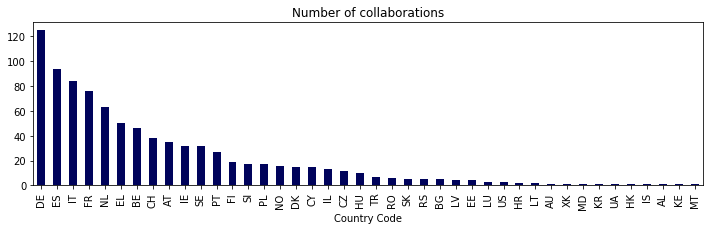

In [145]:
# UK Collaborators
collaborators = flatten_lists([set(country.split(';')) 
                               for country in participationcountries.participantCountries 
                               if type(country) != float])

countries = pd.DataFrame(Counter(collaborators).most_common())
countries.rename(index=str, inplace=True, columns={0:'Country Code', 1:'Number of collaborations'})
countries.set_index('Country Code', inplace=True)

f, ax = plt.subplots(figsize=(12,3))
countries.loc[[c for c in countries.index if c != 'UK']].plot(kind='bar', ax=ax, legend=False, color='xkcd:dark blue')
ax.set_title('Number of collaborations')
f.savefig('../reports/collaborations.png')
plt.show()